# Imports

In [1]:
%config Completer.use_jedi = False
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

# Load Data

## Data Description

- Sex
  - 0 = Male
  - 1 = Female
  
  
- Marital Status
  - 0 = Unmarried
  - 1 = Married
  
  
- Age: Age of Customer


- Education
  - 0 = Primary
  - 1 = middle school
  - 2 = high school
  - 3 = college/graduation


- Income: Income of each customer


- Occupation
  - 0 = Tertiary
  - 1 = Primary
  - 2 = Secondary Occupation
  
  
- Settlement size
  - 0 = Urban
  - 1 = Mixed
  - 2 = Rural

In [2]:
data = pd.read_csv('../input/customer-clustering/segmentation data.csv')
data.drop('ID', axis=1, inplace=True)
data.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


# EDA

In [3]:
data.isnull().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [4]:
data.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [5]:
discrete_features = []
continuous_features = []
for feature in data.columns:
    print(feature, len(data[feature].unique()))
    if len(data[feature].unique()) > 10:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)
        
print()
print('Discrete Features:', discrete_features)
print('Continuous Features:', continuous_features)

Sex 2
Marital status 2
Age 58
Education 4
Income 1982
Occupation 3
Settlement size 3

Discrete Features: ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']
Continuous Features: ['Age', 'Income']


## Observations
- There is no missing values.
- ID column contributes nothing to the dataset so dropped it.
- There is a total of 2000 examples or rows in the dataset.
- The data has 5 Discrete and 2 Continuous Features.

In [6]:
fig = make_subplots(rows=2, cols=3, specs=2*[3*[{'type':'domain'}]])
for i in range(1, 3):
    for j in range(1, 4):
        idx = 3 * (i - 1) + j
        if idx <= len(discrete_features):
            curr_feature = discrete_features[idx-1]
            fig.add_trace(go.Pie(labels=list(Counter(data[curr_feature]).keys()),
                                 values=list(Counter(data[curr_feature]).values()),
                                 title=curr_feature, name=''), row=i, col=j)
            
fig.update_traces(textfont_size=15)
fig.update_layout(height=500, width=900, margin=dict(t=0, b=0, l=0, r=0), font=dict(size=15))
fig.show()

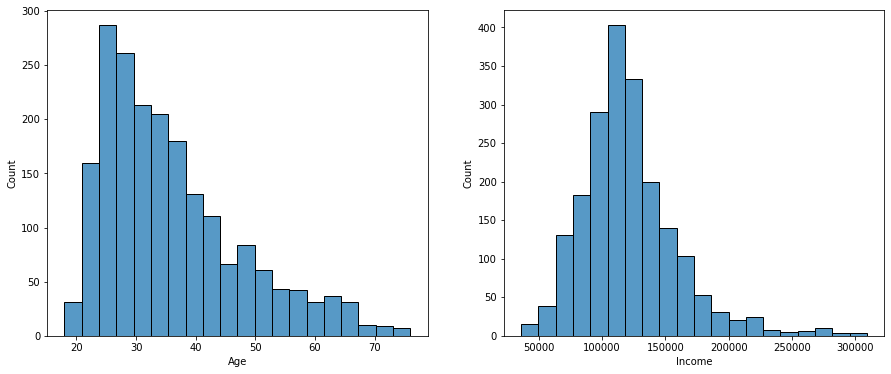

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i, feature in enumerate(continuous_features):
    sns.histplot(ax=ax[i], x=feature, data=data, bins=20)
    
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Income'>

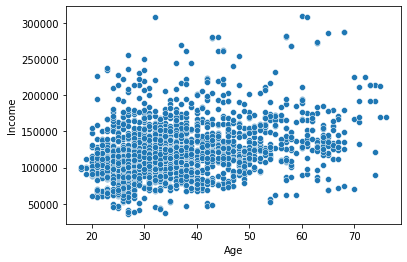

In [8]:
sns.scatterplot(x='Age', y='Income', data=data)

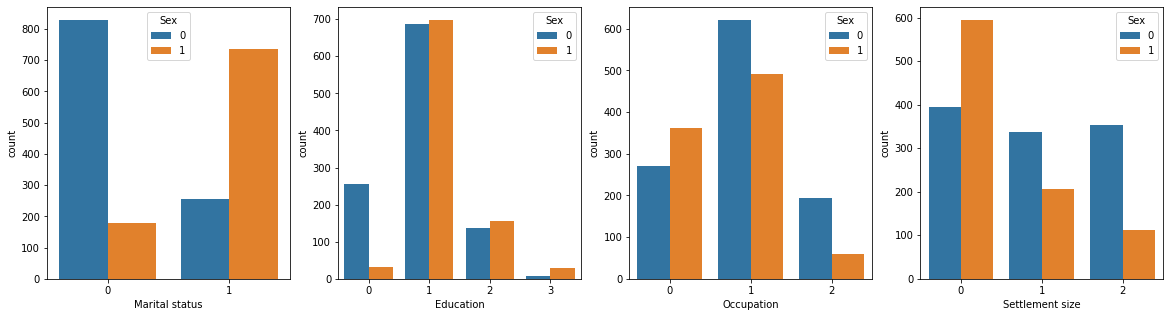

In [9]:
new_discrete_features = discrete_features.copy()
new_discrete_features.remove('Sex')

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    sns.countplot(ax=ax[i], x=new_discrete_features[i], data=data, hue='Sex')

plt.show()


## Key Insights

- No missing values.
- Sex and Marital status is equally distributed.
- No of Graduate individuals(3) are very low.
- Age and Income data are skewed thus a log transformation is to be applied.
- When count of discrete features wrt Sex is presented,
  - Marital status looks highly imbalanced.
  - Male dominates in Primary and Secondary Occupation.
  - Females are deprived of Primary Education while it is balanced with other tiers of education.

# Feature Engineering

In [10]:
transformed_data = data[discrete_features].copy()

for feature in continuous_features:
    transformed_data[feature + '_log'] = np.log(data[feature])
    
transformed_data.head()

,Sex,Marital status,Education,Occupation,Settlement size,Age_log,Income_log
0,0,0,2,1,2,4.204693,11.733426
1,1,1,1,1,2,3.091042,11.923531
2,0,0,1,0,0,3.891820,11.398748
3,0,0,1,1,1,3.806662,12.052717
4,0,0,1,1,1,3.970292,11.911910


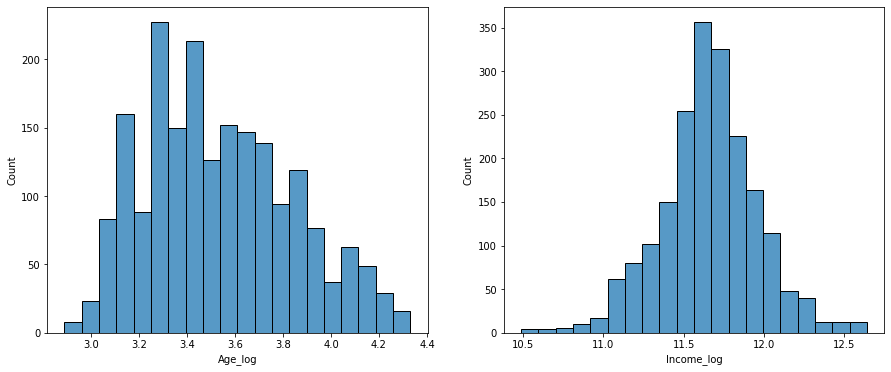

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i, feature in enumerate(continuous_features):
    sns.histplot(ax=ax[i], x=feature + '_log', data=transformed_data, bins=20)
    
plt.show()

In [12]:
scalar = MinMaxScaler()
X = scalar.fit_transform(transformed_data)

In [13]:
X[:5]

array([[0.        , 0.        , 0.66666667, 0.5       , 1.        ,
        0.91249369, 0.57839313],
       [1.        , 1.        , 0.33333333, 0.5       , 1.        ,
        0.13931967, 0.66658126],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.69527579, 0.42313932],
       [0.        , 0.        , 0.33333333, 0.5       , 0.5       ,
        0.63615327, 0.7265099 ],
       [0.        , 0.        , 0.33333333, 0.5       , 0.5       ,
        0.74975629, 0.66119035]])

# Model Building

## KMeans

In [14]:
SSE = [] # Sum of Squared Errors
kmean_sil_scores = []
kmean_index = range(2, 16)
for i in kmean_index:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(X)
    SSE.append(kmeans.inertia_)
    kmean_sil_scores.append(silhouette_score(X, labels))
    
    clear_output(wait=True)
    print('Intertia at i =', i, ':', kmeans.inertia_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

Intertia at i = 15 : 200.1216568716734
Silhouette Coefficient: 0.435


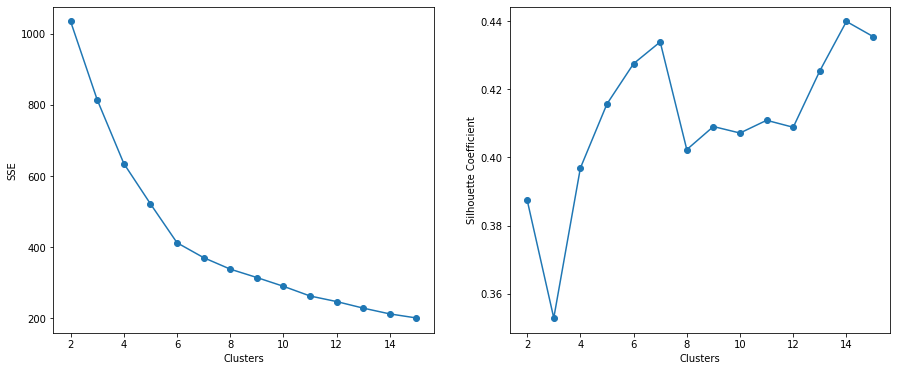

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(kmean_index, SSE, marker='o')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('SSE')

ax[1].plot(kmean_index, kmean_sil_scores, marker='o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Silhouette Coefficient')

plt.show()

## DBSCAN

In [16]:
dbscan_sil_scores = []
dbscan_index = np.arange(0.1, 1.1, 0.1)

for i in dbscan_index:
    dbscan = DBSCAN(eps=i, min_samples=2)
    labels = dbscan.fit_predict(X)
    dbscan_sil_scores.append(silhouette_score(X, labels))

Text(0, 0.5, 'Silhouette Coefficient')

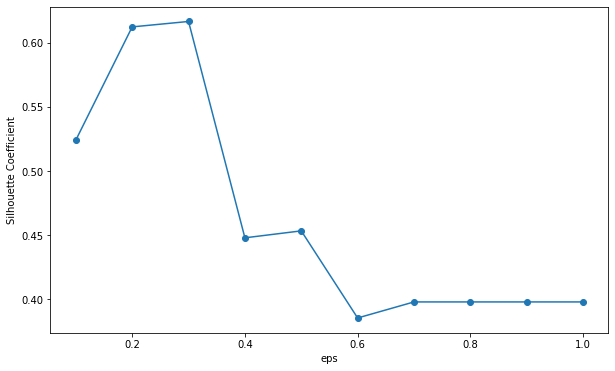

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(dbscan_index, dbscan_sil_scores, marker='o')
plt.xlabel('eps')
plt.ylabel('Silhouette Coefficient')

## Best Model ?
With **KMeans at clusters = 6 or 7** provides high Silhouette score. Also looking at the clusters vs inertia graph, the **elbow method** is applied which interprets the clusters at 6 or 7 to look as elbow point.

Considering the **DBSCAN**, different values of eps and min_samples are tried where variable eps are tested with its Silhouette score. At **eps = 0.2 to 0.3**, DBSCAN provide a good score.

Thus, my conclusion is either KMeans and DBSCAN can be used at the provided parameters to obtain efficient results.

# Future Scope
- While revisiting the dataset, will try more in-depth analysis of the dataset.
- Will try other clustering algorithms and compare the results.